Authorize Google Collab to Access Drive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
code_path = "/content/drive/Shared drives/EGG/Python Codes"
import sys
sys.path.append(code_path)
#%cd /content/drive/Shared drives/EGG/Python Codes#
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
adc.json  drive  sample_data


#Import packages used in data processing

In [0]:
import pandas as pd
pd.set_option('display.max_colwidth', -1,'display.max_rows',999)
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.signal import spectrogram, periodogram, square, firwin, butter, lfilter, filtfilt, sosfreqz, sosfilt
import csv
import time, datetime, sys, os
import scipy.io
from scipy.ndimage import gaussian_filter
from scipy import signal

%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.dates as mdates
import seaborn as sns
sns.set(rc={'image.cmap': 'jet'},style="ticks",font_scale=1.2)


#Define functions that we may use later

In [0]:
##Butterworth bandpass
'''
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
'''
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, fs, order=4):
    # Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
    b, a = butter_lowpass(cutoff_freq, fs, order=order)
    y = filtfilt(b, a, data)
    return y

#RID List

In [5]:
directory = '/content/drive/Shared drives/EGG/MicroSD_Data/' #path where all our SD files are saved
#RID_list = ['SD200124-152100-AW-test']
#RID_list = ['SD200203-105600-AW-gluten']
#RID_list = ['SD200207-113600-AW-viscosityL']
#RID_list = ['SD200207-115400-AW-viscosityL']
#RID_list = ['SD200209-193800-SB-viscosityL']
#RID_list = ['SD200211-174100-QL-viscosityS']
#RID_list = ['SD200209-114600-QL-viscosityL']
RID_list = ['SD200214-134200-JS-gluten']
#RID_list = ['SD200215-105700-AW-glutenF']
#RID_list = ['SD200216-184600-JS-volumeC']
#RID_list = ['SD200219-201500-SB-gluten']
print('length RID_list:', len(RID_list))

length RID_list: 1


#Check if Converted SD file Matches Recording Log

In [0]:
##Define some constants:
fs = 250 #sampling frequency

In [7]:
## Import the data
for ii in range(0,len(RID_list)):
    count = 0
    experiemntData = []
    dtStart = []
    dtStop = []
    path = directory + RID_list[ii] + '.csv'
    print(path)
    with open(path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            count = count + 1
        #print(count)
        x = count - 7
        print('Rows of Data:', x)
        dtStart.append(pd.to_datetime((str(int(RID_list[ii][4:6]))+'/'+str(int(RID_list[ii][6:8]))+'/20'+RID_list[ii][2:4]
                          +' '+str(int(RID_list[ii][9:11]))+':'+RID_list[ii][11:13]+':'+RID_list[ii][13:15])))
        dtStop.append(dtStart[ii]+datetime.timedelta(seconds=x/250))
        print('dtStart', dtStart)
        print('dtStop', dtStop)
        print('Recorded for:', dtStop[0]-dtStart[0])
    data = pd.read_csv(path,skip_blank_lines=True, skiprows=7) #there are 7 rows at the beginning of every file that have %
    duration = len(data)*(1/fs)*(1/60)*(1/60)
    print('Duration:', duration, 'hrs')

/content/drive/Shared drives/EGG/MicroSD_Data/SD200214-134200-JS-gluten.csv
Rows of Data: 3341098
dtStart [Timestamp('2020-02-14 13:42:00')]
dtStop [Timestamp('2020-02-14 17:24:44.392000')]
Recorded for: 0 days 03:42:44.392000
Duration: 3.71233 hrs


#Rename the columns, normalize the data, and visualize some of them

<class 'pandas.core.frame.DataFrame'>
9


,time,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,0.004,1216.456137,-6317.827513,-7843.127692,-2108.17580,-9985.438775,-10707.943325,-12028.259495,-7368.919699
1,0.008,1223.161737,-6310.004313,-7835.975292,-2100.77737,-9977.481775,-10701.997325,-12025.420495,-7364.762699
2,0.012,1218.289237,-6315.011013,-7842.457192,-2106.16415,-9983.359775,-10707.540325,-12027.946495,-7369.411699
3,0.016,1210.868337,-6321.515513,-7848.939092,-2112.73556,-9989.215775,-10711.609325,-12029.287495,-7372.517699
4,0.020,1214.690737,-6316.598013,-7843.775992,-2107.37110,-9982.890775,-10706.222325,-12025.711495,-7366.952699


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


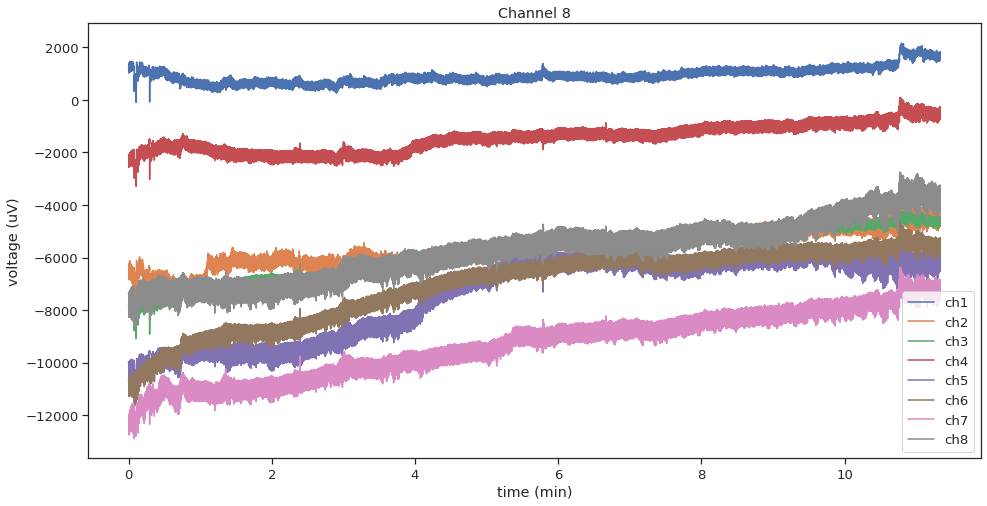

In [8]:
data.columns = ['time', 'ch1', 'ch2', 'ch3', 'ch4', 'ch5', 
                'ch6', 'ch7', 'ch8', 'motion x', 'motion y', 'motion z']
data.drop(data.tail(1).index,inplace=True)
print(type(data))
data.drop(['motion x', 'motion y', 'motion z'], axis=1, inplace=True)
print(data.shape[1])
time = np.arange(1, len(data['ch4'])+1)/fs
for i in range(1,9):
    exec("data['ch"+str(i)+"']=data['ch"+str(i)+"'] - np.mean(data['ch"+str(i)+"'])") #normalize the data
data['time'] = time

##visualizing
st_time = 0 ##seconds * 1/fs
ed_time = 170000  ## seconds * 1/fs
plt.figure(figsize=(16, 8))
for i in range(1,9):
    plt.plot(data['time'][st_time:ed_time]/60, data['ch{}'.format(i)][st_time:ed_time], label='ch{}'.format(i))
plt.xlabel('time (min)')
plt.ylabel('voltage (uV)')
plt.legend()
plt.title('Channel {}'.format(i))
data.head()

#Filter the data and save it as filt_data

In [9]:
##Appying bandpass filter
freq_lo = 0.03
freq_hi = 0.8
order = 5
filt_data = pd.DataFrame()
for i in range(1,9):
    filt_data['ch{}'.format(i)]=butter_bandpass_filter(data['ch{}'.format(i)], freq_lo, freq_hi, fs=250, order=order)
    #print(butter_bandpass_filter(data['ch{}'.format(i)], freq_lo, freq_hi, fs=250, order=5))
    #The setting of lowpass filter is similar and is offered below
    #print(butter_lowpass_filter(data['ch{}'.format(i)], freq_hi, 250,order=5))
filt_data.head()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,1.000157e-07,-5.194447e-07,-6.448532e-07,-1.733319e-07,-8.209917e-07,-8.803952e-07,-9.889501e-07,-6.058644e-07
1,1.094453e-06,-5.680680e-06,-7.052365e-06,-1.895174e-06,-8.978778e-06,-9.628657e-06,-1.081621e-05,-6.626179e-06
2,6.031523e-06,-3.128966e-05,-3.884618e-05,-1.043695e-05,-4.945766e-05,-5.303847e-05,-5.958140e-05,-3.649967e-05
3,2.267652e-05,-1.175933e-04,-1.459963e-04,-3.921930e-05,-1.858779e-04,-1.993392e-04,-2.239336e-04,-1.371803e-04
4,6.631490e-05,-3.438099e-04,-4.268628e-04,-1.146577e-04,-5.434657e-04,-5.828312e-04,-6.547462e-04,-4.010918e-04


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


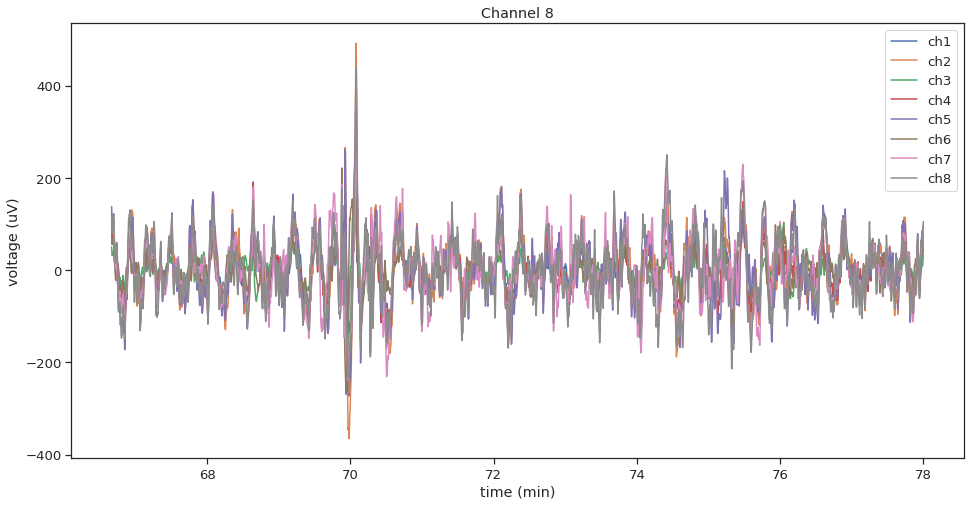

In [10]:
## Visualizing the filtered data
st_time = 1000000 ##seconds * 1/fs
ed_time = 1170000  ## seconds * 1/fs
plt.figure(figsize=(16, 8))
for i in range(1,9):
    plt.plot(data['time'][st_time:ed_time]/60, filt_data['ch{}'.format(i)][st_time:ed_time],label='ch{}'.format(i))
    plt.legend()
    plt.xlabel('time (min)')
    plt.ylabel('voltage (uV)')
    plt.title('Channel {}'.format(i))

In [0]:
win = fs*60*6
meanSignal = np.median(filt_data,axis=1)-sp.signal.wiener(np.median(filt_data,axis=1), mysize=int(120*fs), noise=10000)
#band-pass filter
b = signal.firwin(499,[ 0.035, 0.25], nyq=0.5*fs, window=('kaiser',6.0), pass_zero=False)
meanSignal = signal.filtfilt(b,[1],x=meanSignal)
f,fft = sp.signal.welch(meanSignal,fs=fs,window="hanning",nperseg=win,detrend="linear",scaling='spectrum',nfft=win*4)
fft = fft[(f>0)&(f<0.1)]
f = f[(f>0)&(f<0.1)]
domFreq = f[np.argmax(fft)]

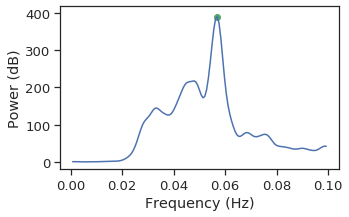

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,3))
ax.plot(f,fft)
loc = np.where(f==domFreq)[0][0]
ax.scatter(f[loc],fft[loc],color=sns.color_palette()[2])
#ax.set_xlim(0.02,0.1)
#ax.set_title('Power Spectral Density')
ax.set_ylabel('Power (dB)')
ax.set_xlabel('Frequency (Hz)');

#Remove Artifacts

In [0]:
window = int(fs*60*4)
wSize = int(1/domFreq*fs)
#wSize = 20
wNoise = 15000

In [0]:
temp_array = data.to_numpy()
#print(temp_array)
data_array = temp_array[:,[1,2,3,4,5,6,7,8]]
#print(data_array)

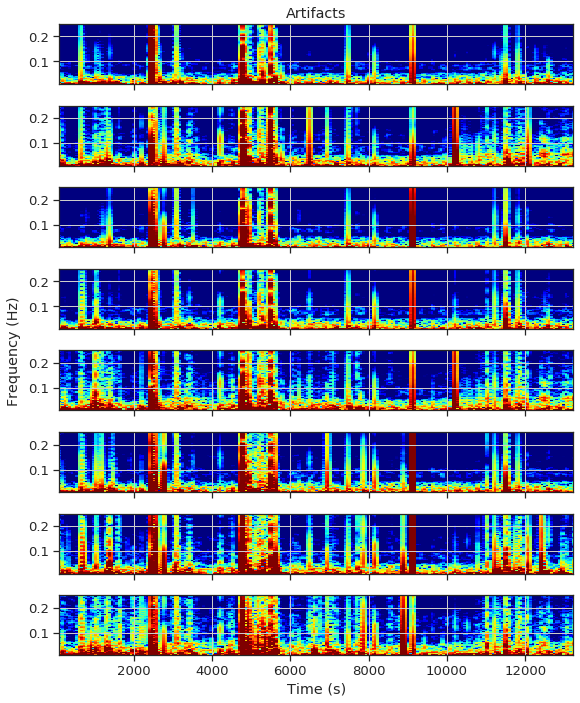

In [15]:
fig, ax = plt.subplots(nrows = data_array.shape[1], ncols = 1, figsize=(8,10), sharex=True)
cm = plt.cm.get_cmap('jet')
ax[0].set_title('Artifacts')
ax[data_array.shape[1]-1].set_xlabel('Time (s)')

artifact = []
for ii in range(0,data_array.shape[1]):
    wiener = sp.signal.wiener(data_array[:,ii], mysize=wSize, noise=wNoise)
    im = ax[ii].specgram(wiener,NFFT=window,Fs=fs,noverlap=window*.75,interpolation='none')
    artifact.append(np.mean(im[0][im[1]>0.05,:],axis=0))
    ax[ii].axis('tight')
    ax[ii].set_ylim([0.01,0.25])
    #ax[ii].set_ylabel('Frequency (Hz)')
    ax[ii].grid(None)
    im[3].set_clim(20,55)

fig.text(-0.01, 0.5, 'Frequency (Hz)', va='center', rotation='vertical')
  
fig.tight_layout()
#cb = plt.colorbar(im[3],ax=ax[1])

In [0]:
for ii in range(0,data_array.shape[1]):
    if np.sum(data_array[:,ii])!=0:
        data_array[:,ii] = data_array[:,ii]-sp.signal.wiener(data_array[:,ii], mysize=wSize, noise=wNoise)

# Finding the "Best" Electrode Pair

In most electrophysiology recordings (e.g. EEG, EMG, etc), one electrode location is chosen as the reference location and the potentials at all the other electrode sites are recorded with respect to the reference by exploiting the properties of differential amplifiers.  This reference point is largely arbitrary.  We have the option of changing the effective reference to another recording site further down the processing chain by simple subtraction.  The original $N$-channel recording with respect to reference location $r$ yields the signals:

$$V_{n} - V_{r} \quad n = 1,N$$

We are free to re-reference to any one of the original recording sites $y$ by the transformation:

$$V_{n}-V_{y} \equiv \left(V_{n}-V_{r}\right) - \left(V_{y}-V_{r}\right) $$

where the potential difference inside the second parenthesis is obtained in the original recording.  This transformation can be applied to any recording location $y$ other than one with noisy data.

If there are $n$ channels that share the same reference, there are a total of ${n\choose 2}$ combinations of electrode pairs.  We will attempt at finding the "best" electrode pair for a given recording by iterating through every combination and assessing its quality.  A subject with normal stomach electrical activity should have a constant 3cpm (0.05Hz) throughout the recording.  If we assume the EGG data is from a normal subject, the pair with peak power of 2-4cpm (0.033-0.067Hz) during most of the recording should be the highest "quality".

In [0]:
iter = 0
spec,freqs,t = mlab.specgram(data_array[:,0]-0,NFFT=window,Fs=fs,noverlap=window*.75)
percent3cpm = np.zeros(int(scipy.special.comb(data_array.shape[1],2)))
snr = np.zeros(int(scipy.special.comb(data_array.shape[1],2)))
power3cpm = np.zeros([int(scipy.special.comb(data_array.shape[1],2)),t.size])
pairs = np.zeros([int(scipy.special.comb(data_array.shape[1],2)),2],dtype=int)
from itertools import combinations
for pair in combinations(range(data_array.shape[1]),2):
    dataTest = data_array[:,pair[0]]-data_array[:,pair[1]]
    spec,freqs,t = mlab.specgram(dataTest,NFFT=window,Fs=fs,noverlap=window*.75)
    spec = 10*np.log10(spec)
    ind = np.argmax(spec,axis=0)
    percent3cpm[iter] = ((0.033<freqs[ind])&(freqs[ind]<0.067)).sum()/np.size(t)
    power3cpm[iter] = np.max(spec[(domFreq-0.01<freqs)&(freqs<domFreq+0.01),:],axis=0)#-np.median(spec[((0.075<freqs)&(freqs<0.15)),:])
    f,fft = sp.signal.welch(dataTest,fs=fs,window="hanning",nperseg=fs*60*6,nfft=fs*60*6*4,
                            detrend="linear",scaling='spectrum')
    snr[iter] = np.max(fft[(f>0.03)&(f<0.07)])#/np.min(fft[(f>0.03)&(f<0.07)])
    pairs[iter,:] = pair
    iter += 1

#select best pairs
numTopPairs = 6
ind = snr.argsort()[-numTopPairs:][::-1]

## STFT Spectrogram of Best Pairs

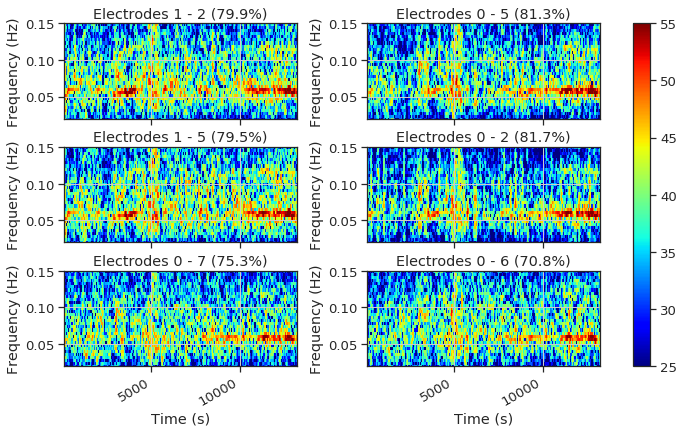

In [18]:
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(12,7))
fig.subplots_adjust(hspace=0.3,wspace=0.3)

iter=0
for ii in range(0,3):
    for jj in range(0,2):
        im = ax[ii,jj].specgram(data_array[:,pairs[ind[iter],0]]-data_array[:,pairs[ind[iter],1]],
                                NFFT=window,Fs=fs,noverlap=window*.75,interpolation='none')
        ax[ii,jj].axis('tight')
        ax[ii,jj].set_ylim([0.02,0.15])
        ax[ii,jj].set_ylabel('Frequency (Hz)')
        ax[ii,jj].set_xlabel('Time (s)')
        ax[ii,jj].set_title("Electrodes %d - %d (%.1f%%)" % 
                            (pairs[ind[iter],0],pairs[ind[iter],1],percent3cpm[ind[iter]]*100))
        ax[ii,jj].grid(None)
        im[3].set_clim(25,55)
        fig.autofmt_xdate()
        iter+=1

cb = fig.colorbar(im[3], ax=ax.ravel().tolist())